In [51]:
import pandas as pd

X = pd.read_csv('x_v1.csv')
y = pd.read_csv('target.csv')

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89213 entries, 0 to 89212
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProcessingTime            89213 non-null  float64
 1   config                    89213 non-null  float64
 2   is_dep_B                  89213 non-null  float64
 3   is_local                  89213 non-null  float64
 4   departure_equals_checkin  89213 non-null  float64
dtypes: float64(5)
memory usage: 3.4 MB


In [52]:
rolls = [5, 15, 30, 60, 120]
rolled = [X]

for roll in rolls:
    rolled.append(X.rolling(roll).mean().rename(columns={c: c+f'_{roll}' for c in X.columns}))
    rolled.append(y.rolling(roll).mean().rename(columns={'MessageReceivedMinutes': f'MessageReceivedMinutes_{roll}'}))
    
X = pd.concat(rolled, axis=1)
    
X = X.iloc[max(rolls):]
y = y.iloc[max(rolls):]

In [53]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

tscv = TimeSeriesSplit(n_splits=5)
for train_idx, val_idx in tscv.split(X):
    train_X = X.iloc[train_idx]
    train_y = y.iloc[train_idx]
    
    val_X = X.iloc[val_idx]
    val_y = y.iloc[val_idx]
    
    lr = LinearRegression()
    lr.fit(train_X, train_y)
    
    print(f'split: {round(len(train_idx)/len(X), 2)}/{round(len(val_idx)/len(X), 2)}, MAPE: {mean_absolute_percentage_error(lr.predict(val_X), val_y)}')

split: 0.17/0.17, MAPE: 0.14847595715003753
split: 0.33/0.17, MAPE: 0.15113403803271536
split: 0.5/0.17, MAPE: 0.1494287841300959
split: 0.67/0.17, MAPE: 0.14703667574101265
split: 0.83/0.17, MAPE: 0.1489439141543168


<BarContainer object of 35 artists>

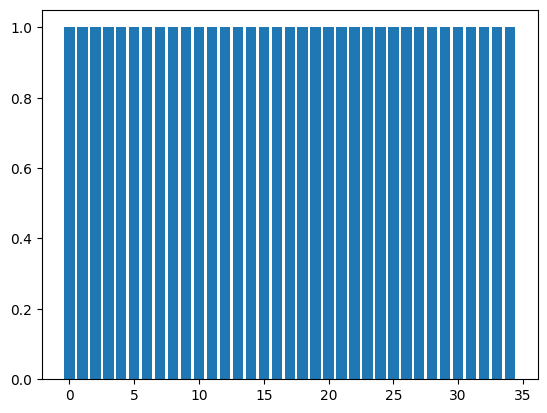

In [54]:
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import numpy as np

selector = RFECV(LinearRegression(), step=1, cv=tscv.split(X))
selector.fit(X.to_numpy(), y.to_numpy())

plt.bar(np.arange(len(X.columns)), selector.ranking_)